In [124]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
import itertools
import sympy as sp

import gamelab.finitegames as nfg
import symplecticFTRL

## Utils

In [100]:
# switch between coords and points
def coords_points(L):

	#https://stackoverflow.com/questions/2921847/what-does-the-star-operator-mean-in-a-function-call
	def make(*values):
		return values

	return make(*zip(*L))

In [101]:
def flatten(packed):
    #return [e  for l in [list(x) for x in packed] for e in l ]
    return [e for l in packed for e in l ]

# Symplectic FTRL on mixed extension of $[2 \times 2 \times 2
]$ normal form games

In [105]:
skeleton = [2,2,2]

In [107]:
BARE = nfg.NFG_bare(skeleton, "numeric")

In [103]:
# generalized harmonic
payoff = [-21, -16, 2, 21, -4, -8, -9, 7, 6, 24, 9, -4, -7, -8, 3, 7, 20, 0, -7, 7, 2, 9, -2, -3]
GH = nfg.NFG(skeleton, 'numeric', 'Generalized Harmonic', nfg.u_flat_to_tensor(payoff, skeleton))

# potential
payoff = [-7, -10, -39, -8, -4, -8, -9, 7, 13, -6, 9, -4, -20, -8, 3, 7, -8, 0, -7, 7, 2, 9, -2, -3]
POT = nfg.NFG(skeleton, 'numeric', 'Potential', nfg.u_flat_to_tensor(payoff, skeleton))


In [104]:
GAMES = [GH] #, POT]

In [109]:
primal_vars = BARE.primal_vars
primal_vars

[x0_0, x0_1, x1_0, x1_1, x2_0, x2_1]

In [110]:
dual_vars = BARE.make_vars('y', skeleton)
dual_vars

[y0_0, y0_1, y1_0, y1_1, y2_0, y2_1]

In [120]:
# LOGIT CHOICE
sym_choice = [
    sp.exp(dual_vars[0]) / ( sp.exp(dual_vars[0]) +  sp.exp(dual_vars[1])),
    sp.exp(dual_vars[1]) / ( sp.exp(dual_vars[0]) +  sp.exp(dual_vars[1])),
    sp.exp(dual_vars[2]) / ( sp.exp(dual_vars[2]) +  sp.exp(dual_vars[3])),
    sp.exp(dual_vars[3]) / ( sp.exp(dual_vars[2]) +  sp.exp(dual_vars[3])),
    sp.exp(dual_vars[4]) / ( sp.exp(dual_vars[4]) +  sp.exp(dual_vars[5])),
    sp.exp(dual_vars[5]) / ( sp.exp(dual_vars[4]) +  sp.exp(dual_vars[5])),
]

In [121]:
import choice
logit = choice.Logit(skeleton, "y")
logit.sym_Q

[exp(y0_0)/(exp(y0_0) + exp(y0_1)),
 exp(y0_1)/(exp(y0_0) + exp(y0_1)),
 exp(y1_0)/(exp(y1_0) + exp(y1_1)),
 exp(y1_1)/(exp(y1_0) + exp(y1_1)),
 exp(y2_0)/(exp(y2_0) + exp(y2_1)),
 exp(y2_1)/(exp(y2_0) + exp(y2_1))]

In [123]:
logit.sym_Q == sym_choice

True

# Just defined class to generate logic choice

# Investigate $V \circ Q$ vs $Q^{\ast}V$

In [112]:
SFTRL_GAMES = [ symplecticFTRL.SFTRL(flatten(game.payfield), sym_choice, primal_vars, dual_vars, game.name) for game in GAMES ]

In [113]:
SFTRL_GAMES[0].sftrl_dyn([1, 2, 3, 5, 4, 1], 0, 0)

array([ 0.08027815, -7.75823747, -3.30884654,  4.58652073, -2.13054754,
        0.51073582])

## ODE

In [114]:
time = np.linspace(0, 15, 10000)

In [115]:
import random

num_orbits = 10

initial_dual_points = [[random.uniform(-5, 5) for _ in range(6)] for n in range(num_orbits)]
#initial_dual_points = [ [2, 2.5, 2.1, 2.4, 2.2, 2.3] ]

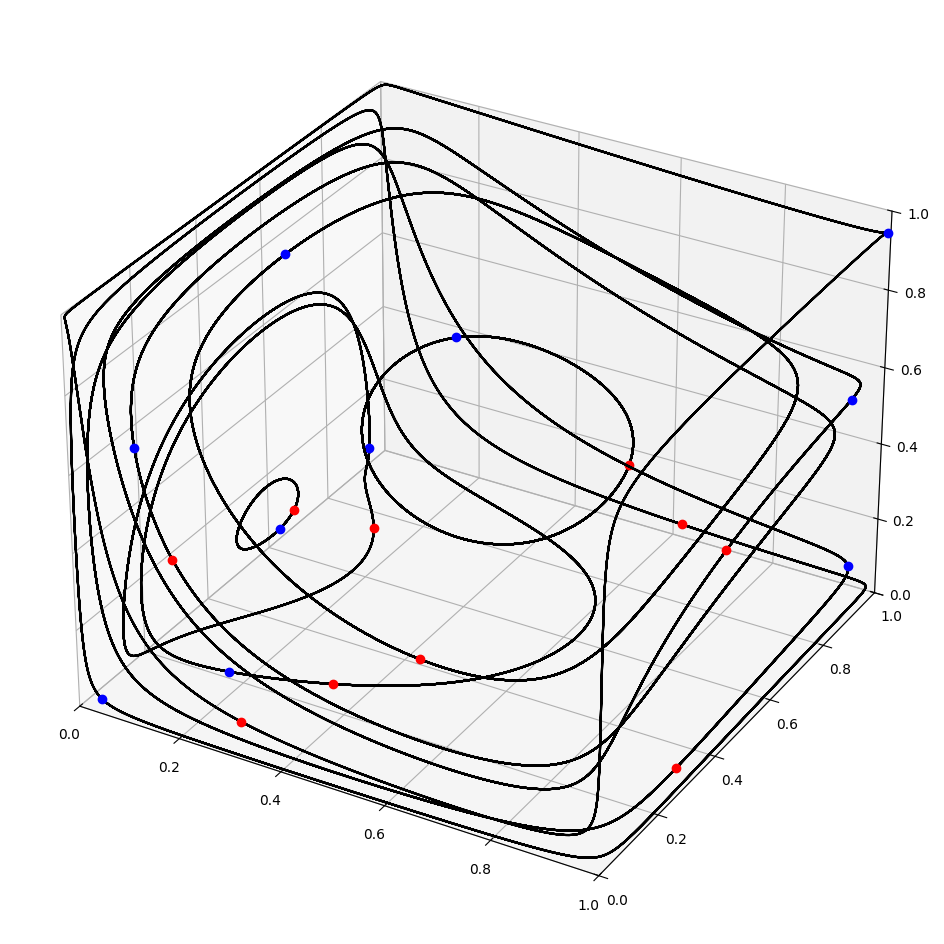

In [116]:
fig = plt.figure(figsize=(12, 12))


for i, s in enumerate(SFTRL_GAMES):
    ax = fig.add_subplot(len(SFTRL_GAMES), 1, i+1, projection='3d')
    
    for y0 in initial_dual_points:

        dual_points = odeint(s.sftrl_dyn, y0, time, args = (-0.0,))
        primal_points = [s.choice(*y) for y in dual_points]
        x00, x01, x10, x11, x20, x21 = coords_points(primal_points) # primal coords
        ax.plot(x01, x11, x21, 'k')
        ax.plot(x01[0], x11[0], x21[0], 'bo', label = 'initial')
        ax.plot(x01[1000], x11[1000], x21[1000], 'ro', label = 'final')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(0,1)
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
    #plt.title(f'Standard FTRL in {s.name} (finite games $\\to$ constrained setting & entropic regularizer)')
    #plt.show()

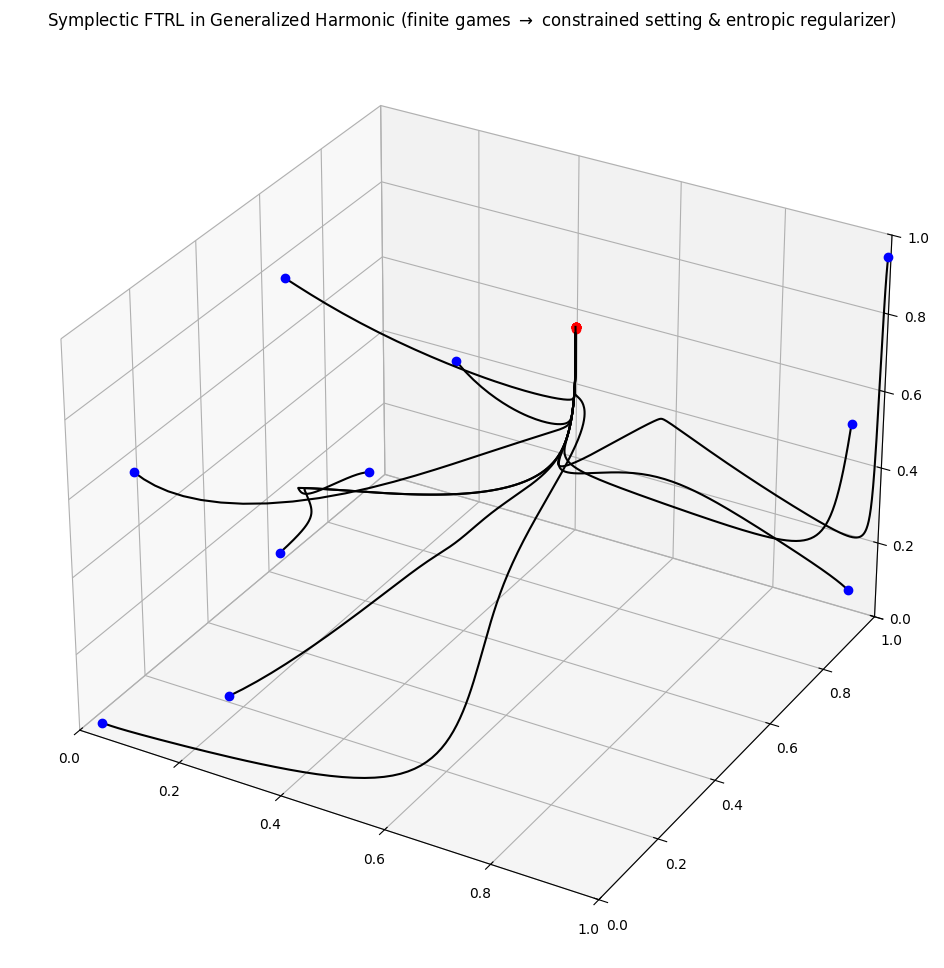

In [117]:
fig = plt.figure(figsize=(12, 12))


for i, s in enumerate(SFTRL_GAMES):
    ax = fig.add_subplot(len(SFTRL_GAMES), 1, i+1, projection='3d')
    
    for y0 in initial_dual_points:

        dual_points = odeint(s.sftrl_dyn, y0, time, args = (-0.5,))
        primal_points = [s.choice(*y) for y in dual_points]
        x00, x01, x10, x11, x20, x21 = coords_points(primal_points) # primal coords
        ax.plot(x01[-1], x11[-1], x21[-1], 'ro', label = 'final')
        ax.plot(x01, x11, x21, 'k')
        ax.plot(x01[0], x11[0], x21[0], 'bo', label = 'initial')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(0,1)
        
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
    plt.title(f'Symplectic FTRL in {s.name} (finite games $\\to$ constrained setting & entropic regularizer)')
    #plt.show()

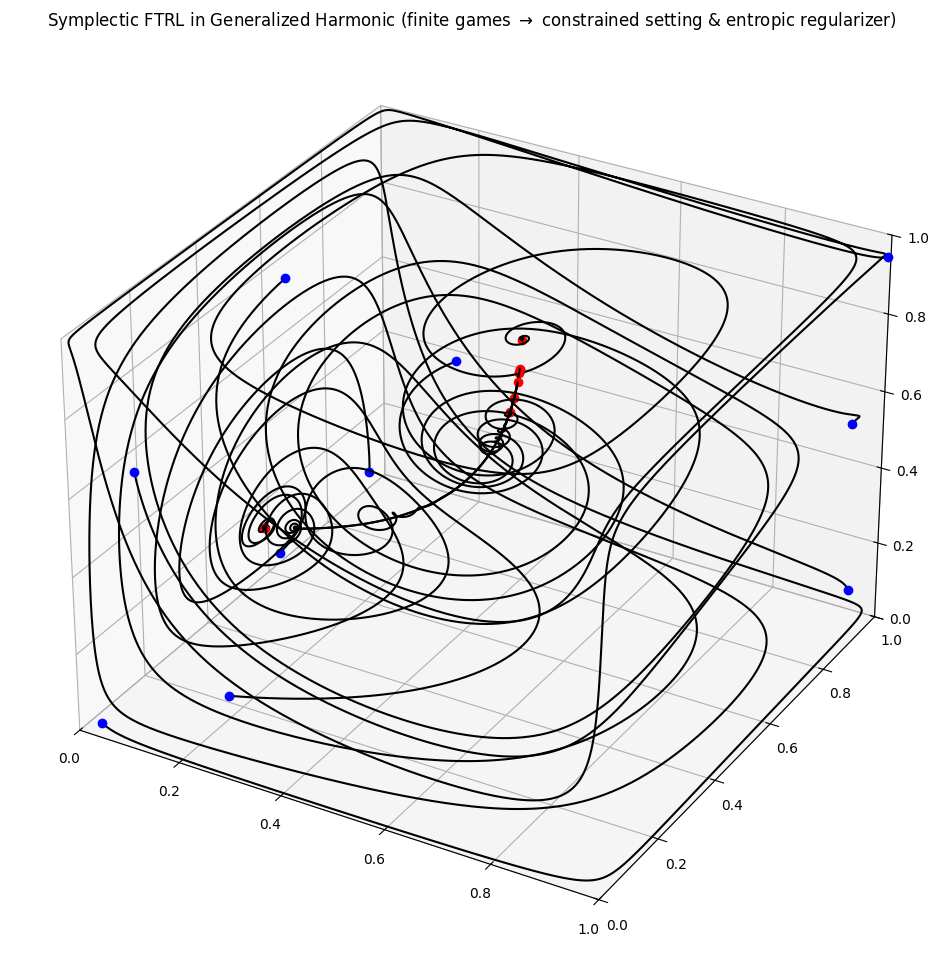

In [118]:
fig = plt.figure(figsize=(12, 12))

time = np.linspace(0, 25, 10000)

for i, s in enumerate(SFTRL_GAMES):
    ax = fig.add_subplot(len(SFTRL_GAMES), 1, i+1, projection='3d')
    
    for y0 in initial_dual_points:

        dual_points = odeint(s.sftrl_dyn, y0, time, args = (-0.01,))
        primal_points = [s.choice(*y) for y in dual_points]
        x00, x01, x10, x11, x20, x21 = coords_points(primal_points) # primal coords
        ax.plot(x01[-1], x11[-1], x21[-1], 'ro', label = 'final')
        ax.plot(x01, x11, x21, 'k')
        ax.plot(x01[0], x11[0], x21[0], 'bo', label = 'initial')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(0,1)
        
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
    plt.title(f'Symplectic FTRL in {s.name} (finite games $\\to$ constrained setting & entropic regularizer)')
    #plt.show()

# It seems to converge to A critical point (rather than a manifold, like FTRL+), but which one depends on $\lambda$

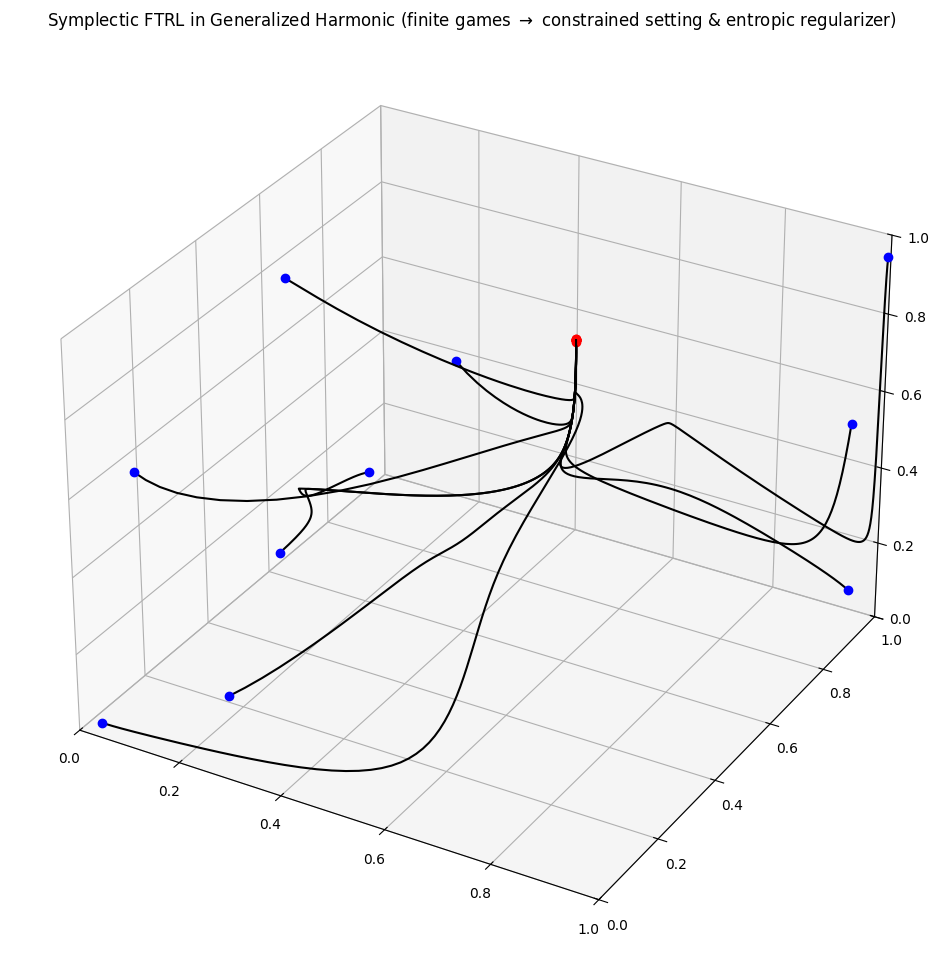

In [119]:
time = np.linspace(0, 15, 10000)
fig = plt.figure(figsize=(12, 12))


for i, s in enumerate(SFTRL_GAMES):
    ax = fig.add_subplot(len(SFTRL_GAMES), 1, i+1, projection='3d')
    
    for y0 in initial_dual_points:

        dual_points = odeint(s.sftrl_dyn, y0, time, args = (-0.6,))
        primal_points = [s.choice(*y) for y in dual_points]
        x00, x01, x10, x11, x20, x21 = coords_points(primal_points) # primal coords
        ax.plot(x01[-1], x11[-1], x21[-1], 'ro', label = 'final')
        ax.plot(x01, x11, x21, 'k')
        ax.plot(x01[0], x11[0], x21[0], 'bo', label = 'initial')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(0,1)
        
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
    plt.title(f'Symplectic FTRL in {s.name} (finite games $\\to$ constrained setting & entropic regularizer)')
    #plt.show()

# $\dot{y} = V \circ Q + \lambda \,  d(V \circ Q)(V \circ Q)$

## $Q = \text{id}$ is SGA